# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [9]:
print(env.action_space)
print(env.observation_space)
state = env.reset()
print(state)
state = env.step(0)
state = env.step(1)
state = env.step(1)
print(state)
state = env.step(2)
print(state)

Discrete(4)
Discrete(48)
36
(26, -1, False, {'prob': 1.0})
(36, -100, False, {'prob': 1.0})


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

/home/ed/.virtualenvs/deeprl/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


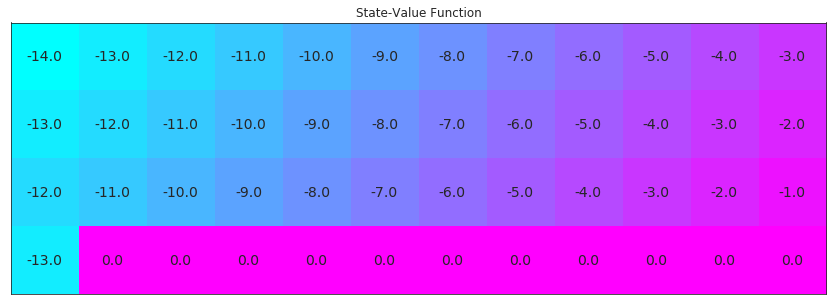

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [105]:
import random
def GLIE(convergence_iters, iter_num, final_val):
    if iter_num <= convergence_iters:
        epsilon = (((final_val - 1)/convergence_iters)*iter_num) + 1
    else:
        epsilon = final_val
    return epsilon

def GLIE_asymp(iter_num):
    return 1/iter_num

def epsilon_greedy(Qs, epsilon):
    policy_s = epsilon * np.ones(Qs.shape[0])/Qs.shape[0]
    max_index = np.argmax(Qs)
    policy_s[max_index] = 1 - epsilon + (epsilon/Qs.shape[0])
    return policy_s

def quick_epsilon_greedy(env, Qs, epsilon):
    if random.random() > epsilon: # select greedy action with probability epsilon
        return np.argmax(Qs)
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))
    
def choose_At1_from_Q(env, state, Q, epsilon):
    if state in Q:
            probs = epsilon_greedy(Q[state], epsilon)
            action = np.random.choice(np.arange(env.nA), p=probs)
    else:
        action = env.action_space.sample()              
    return action

def quick_choose_At1_from_Q(env, state, Q, epsilon):
    action = quick_epsilon_greedy(env, Q[state], epsilon)       
    return action

def update_Q_sarsa(Q, alpha, gamma, st, at, rt_1, st_1 = None, at_1 = None):
    if st_1 == None:
        Q[st][at] = Q[st][at] + alpha*(rt_1 - Q[st][at])
    else:
        Q[st][at] = Q[st][at] + alpha*((rt_1 + (gamma*Q[st_1][at_1])) - Q[st][at]) 
    return Q

def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    convergence_iters = int(num_episodes/3)
    temp_scores = deque(maxlen=num_episodes)
    avg_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        #epsilon = GLIE(convergence_iters, i_episode, 1/num_episodes)
        epsilon = GLIE_asymp(i_episode)
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} epsilon = {} .".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        st = env.reset()
        at = choose_At1_from_Q(env, st, Q, epsilon)
        index = 0
        episode_score = 0
        while True:
            #print("\rindex: {} ".format(index), end="")
            #sys.stdout.flush()   
            # Take action At, observe (Rt+1, St+1)
            #print("st = " + str(st) + " at = " + str(at))
            st_1, rt_1, done, info = env.step(at)
            episode_score += rt_1
                
            if done:
                #print(" Episode length: " + str(index))
                temp_scores.append(episode_score)
                Q = update_Q_sarsa(Q, alpha, gamma, st, at, rt_1)
                break
                
            #print("st_1 = " + str(st_1) + " rt_1 = " + str(rt_1) + "done: " + str(done))
            # Choose action At+1
            at_1 = quick_choose_At1_from_Q(env, st_1, Q, epsilon)
            # Update action value
            Q = update_Q_sarsa(Q, alpha, gamma, st, at, rt_1, st_1, at_1)
            
            st = st_1
            at = at_1
            index += 1
        if (i_episode % 100 == 0):
            avg_scores.append(np.mean(temp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Episode Reward')
    plt.show()
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000 epsilon = 0.0002 .08163265306123 .

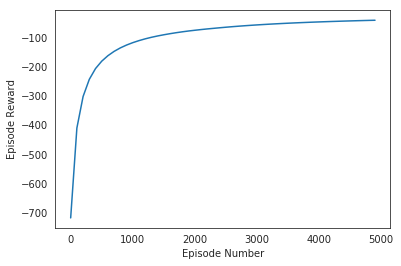

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  2  1  1  0  1  3  2  2  2]
 [ 3  0  1  1  1  1  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


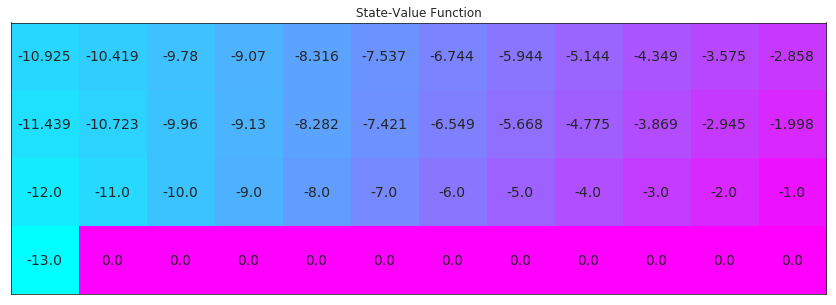

In [106]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [143]:
def update_Q_sarsamax(Q, alpha, gamma, st, at, rt_1, st_1 = None):
    if st_1 == None:
        Q[st][at] = Q[st][at] + alpha*(rt_1 - Q[st][at])
    else:
        Q[st][at] = Q[st][at] + alpha*((rt_1 + (gamma*np.max(Q[st_1]))) - Q[st][at]) 
    return Q

def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    convergence_iters = int(num_episodes/3)
    temp_scores = deque(maxlen=num_episodes)
    avg_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        #epsilon = GLIE(convergence_iters, i_episode, 1/num_episodes)
        epsilon = GLIE_asymp(i_episode)
        #epsilon = 0.005
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} epsilon = {} .".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        st = env.reset()
        index = 0
        episode_score = 0
        while True:
            # Choose action At
            at = quick_choose_At1_from_Q(env, st, Q, epsilon)
            # Take action At, observe (Rt+1, St+1)
            st_1, rt_1, done, info = env.step(at)
            episode_score += rt_1
                
            if done:
                #print(" Episode length: " + str(index))
                temp_scores.append(episode_score)
                Q = update_Q_sarsamax(Q, alpha, gamma, st, at, rt_1)
                break
            
            # Update action value
            Q = update_Q_sarsamax(Q, alpha, gamma, st, at, rt_1, st_1)
            
            st = st_1
            index += 1
        if (i_episode % 100 == 0):
            avg_scores.append(np.mean(temp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Episode Reward')
    plt.show()
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000 epsilon = 0.0002 .08163265306123 .

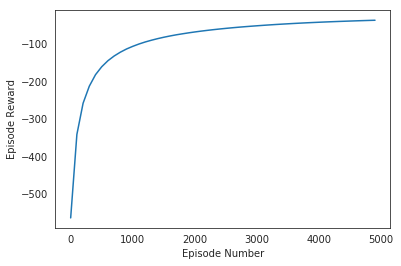

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  0  3  1  2  1  1  1  1  1  2  1]
 [ 1  2  1  2  2  1  1  2  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


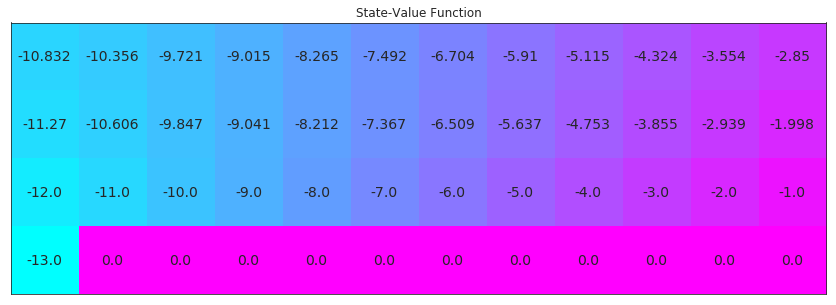

In [144]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [156]:
def update_Q_expected_sarsa(Q, alpha, gamma, epsilon, st, at, rt_1, st_1 = None):
    if st_1 == None:
        Q[st][at] = Q[st][at] + alpha*(rt_1 - Q[st][at])
    else:
        expected_value = Q[st_1].dot(epsilon_greedy(Q[st_1], epsilon))
        Q[st][at] = Q[st][at] + alpha*((rt_1 + (gamma*expected_value)) - Q[st][at]) 
    return Q

def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    convergence_iters = int(num_episodes/3)
    temp_scores = deque(maxlen=num_episodes)
    avg_scores = deque(maxlen=num_episodes)
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        #epsilon = GLIE(convergence_iters, i_episode, 1/num_episodes)
        #epsilon = GLIE_asymp(i_episode)
        epsilon = 0.005
        if i_episode % 100 == 0:
            print("\rEpisode {}/{} epsilon = {} .".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        st = env.reset()
        index = 0
        episode_score = 0
        while True:
            # Choose action At
            at = quick_choose_At1_from_Q(env, st, Q, epsilon)
            # Take action At, observe (Rt+1, St+1)
            st_1, rt_1, done, info = env.step(at)
            episode_score += rt_1
                
            if done:
                #print(" Episode length: " + str(index))
                temp_scores.append(episode_score)
                Q = update_Q_expected_sarsa(Q, alpha, gamma, epsilon, st, at, rt_1)
                break
            
            # Update action value
            Q = update_Q_expected_sarsa(Q, alpha, gamma, epsilon, st, at, rt_1, st_1)
            
            st = st_1
            index += 1
        if (i_episode % 200 == 0):
            avg_scores.append(np.mean(temp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Episode Reward')
    plt.show()
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000 epsilon = 0.005 .

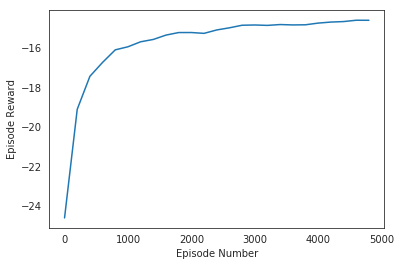

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  2  2  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


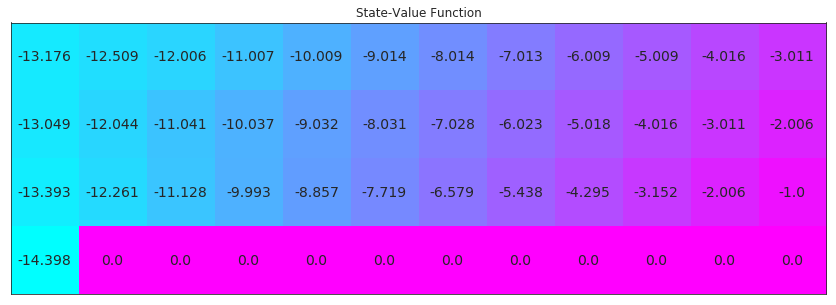

In [157]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])